# 回归问题

根据汽车属性参数预测油耗，可应用场景：预测气温、机器翻译、智能问答

## 1. 导入包，并打印版本信息

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

boston_housing = tf.keras.datasets.boston_housing
models = tf.keras.models
layers = tf.keras.layers
activations = tf.keras.activations
optimizers = tf.keras.optimizers
losses = tf.keras.losses

print('tensorflow: ' + tf.__version__)
print('pandas: ' + pd.__version__)
print('numpy: ' + np.__version__)
print('matplotlib: ' + matplotlib.__version__)
print('seaborn: ' + sns.__version__)

tensorflow: 1.14.0
pandas: 0.25.0
numpy: 1.16.4
matplotlib: 3.1.0
seaborn: 0.9.0


## 2. 准备样本数据
汽车数据

<table style="width:100%">
    <thead>
        <tr>
            <th style="text-align: left;">栏位</th>
            <th style="text-align: left;">说明</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left;">MPG</td>
            <td style="text-align: left;">油耗， 需要预测的数据</td>           
        </tr>
        <tr>
            <td style="text-align: left;">Cylinders</td>
            <td style="text-align: left;">汽缸数</td>           
        </tr>
        <tr>
            <td style="text-align: left;">Displacement</td>
            <td style="text-align: left;">排量</td>           
        </tr>
        <tr>
            <td style="text-align: left;">Horsepower</td>
            <td style="text-align: left;">马力</td>           
        </tr>
        <tr>
            <td style="text-align: left;">Weight</td>
            <td style="text-align: left;">重量</td>           
        </tr>
        <tr>
            <td style="text-align: left;">Acceleration</td>
            <td style="text-align: left;">加速度</td>           
        </tr>
        <tr>
            <td style="text-align: left;">Model Year</td>
            <td style="text-align: left;">生产年份</td>           
        </tr>
        <tr>
            <td style="text-align: left;">Origin</td>
            <td style="text-align: left;">产地， 1: 美国，2: 欧洲，3: 日本</td>           
        </tr>        
    </tbody>
</table>

In [2]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## 3. 预处理数据

### 3.1 清理无效数据

#### 3.1.1 查看无效数据

In [3]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

#### 3.1.2 清理无效数据

In [4]:
dataset = dataset.dropna()

#### 3.1.3 再来看一下

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

### 3.2 处理类别栏位
`Origin`栏位通过值1，2，3来标识产地，这里把它转换成One-Hot模式，注意下面的输出，`Origin`栏位被移除，增加 `USA`、`Europe`、`Japan` 3个栏位

In [6]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 3.3 将数据分离成训练集和测试集

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print('dataset.shape: ' + str(dataset.shape))
print('train_dataset.shape: ' + str(train_dataset.shape))
print('test_dataset.shape： ' + str(test_dataset.shape))

dataset.shape: (392, 10)
train_dataset.shape: (314, 10)
test_dataset.shape： (78, 10)


### 3.4 看一下数据分布
通俗一点：看点是不是能聚在一起
[seaborn.pairplot文档说明](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot)

#### 3.4.1 用图来查看数据分布

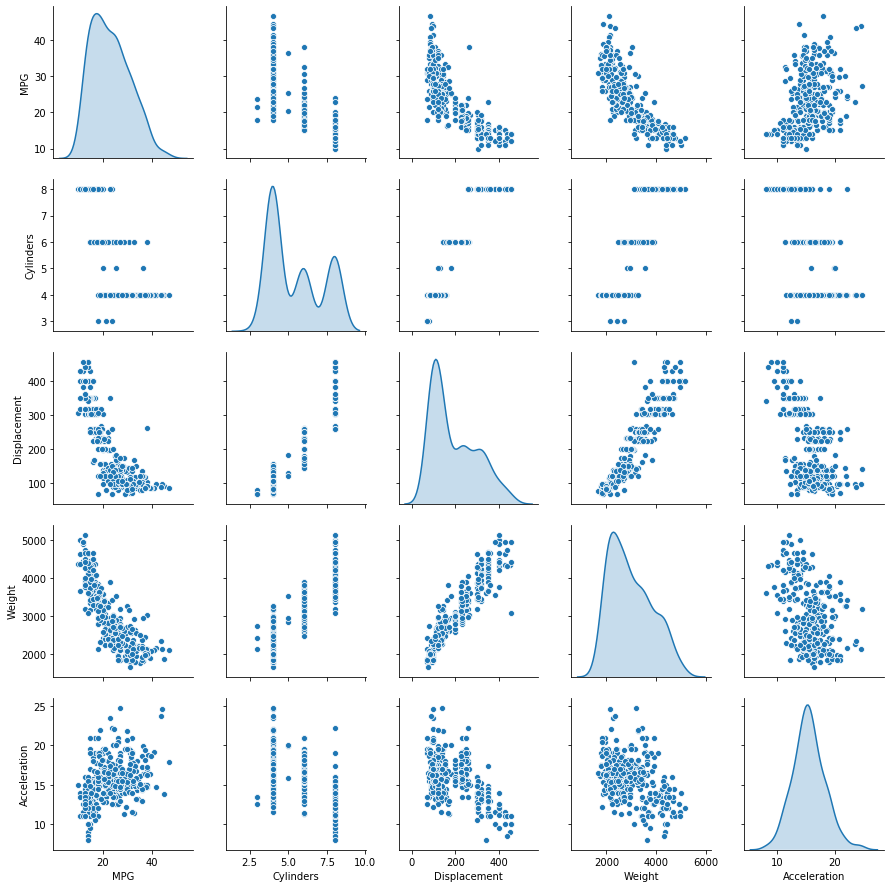

In [8]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight", "Acceleration"]], diag_kind="kde")
plt.show()

#### 3.4.2 使用Pandas查看数据分布

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
print(train_stats)

              count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe       

### 3.5 分别从训练数据和测试数据中分理出标签数据

In [10]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 3.6 数据标准化
NOTE: std决定是不是需要标准化，这里使用Pandas处理，也可以使用numpy处理
```python
normed_train_data = train_dataset.to_numpy()
mean = normed_train_data.mean(axis=0)
normed_train_data -= mean
std = normed_train_data.std(axis=0)
normed_train_data /= std

normed_test_data = test_dataset.to_numpy()
normed_test_data -=mean
normed_test_data /=std

```

In [11]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### 3.7 再来看一下标准化后的数据

In [12]:
train_stats = normed_train_data.describe()
train_stats = train_stats.transpose()
print(train_stats)

              count          mean  std       min       25%       50%  \
Cylinders     314.0  1.824443e-16  1.0 -1.457657 -0.869348 -0.869348   
Displacement  314.0  8.627211e-17  1.0 -1.220325 -0.860894 -0.424785   
Horsepower    314.0 -9.900078e-18  1.0 -1.545283 -0.751241 -0.272190   
Weight        314.0 -8.485781e-17  1.0 -1.589352 -0.869478 -0.198782   
Acceleration  314.0 -5.148041e-16  1.0 -2.710152 -0.630725 -0.021237   
Model Year    314.0  9.772791e-16  1.0 -1.604642 -0.788458  0.027726   
USA           314.0  7.920062e-17  1.0 -1.286751 -1.286751  0.774676   
Europe        314.0  1.980016e-17  1.0 -0.465148 -0.465148 -0.465148   
Japan         314.0  5.374328e-17  1.0 -0.495225 -0.495225 -0.495225   

                   75%       max  
Cylinders     1.483887  1.483887  
Displacement  0.675074  2.489002  
Horsepower    0.607162  3.153347  
Weight        0.732017  2.547401  
Acceleration  0.588250  3.313017  
Model Year    0.843910  1.660094  
USA           0.774676  0.774676  

## 4.  创建模型

In [13]:
model = models.Sequential(
    [
        # NOTE： 飞驰人生：一顿操作猛如虎，定睛一看原地杵。
        layers.Dense(64, activation=activations.relu, input_shape=(normed_train_data.shape[1],)),
        layers.Dense(64, activation=activations.relu),
        layers.Dense(1)
    ]
)

model.compile(
    loss=losses.mean_squared_error,
    optimizer=optimizers.RMSprop(0.001),
    metrics=['mean_absolute_error', 'mean_squared_error']
)

model.summary()


W0730 09:16:25.596534 140583863031616 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## 5. 训练模型

In [14]:
# 这里迭代10000次，通过EarlyStopping监控val_loss， 10次val_loss没有改善，终止学习
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=10000, 
    validation_split = 0.2,
    verbose=0, 
    callbacks=[early_stop]
)

## 6. 查看训练结果

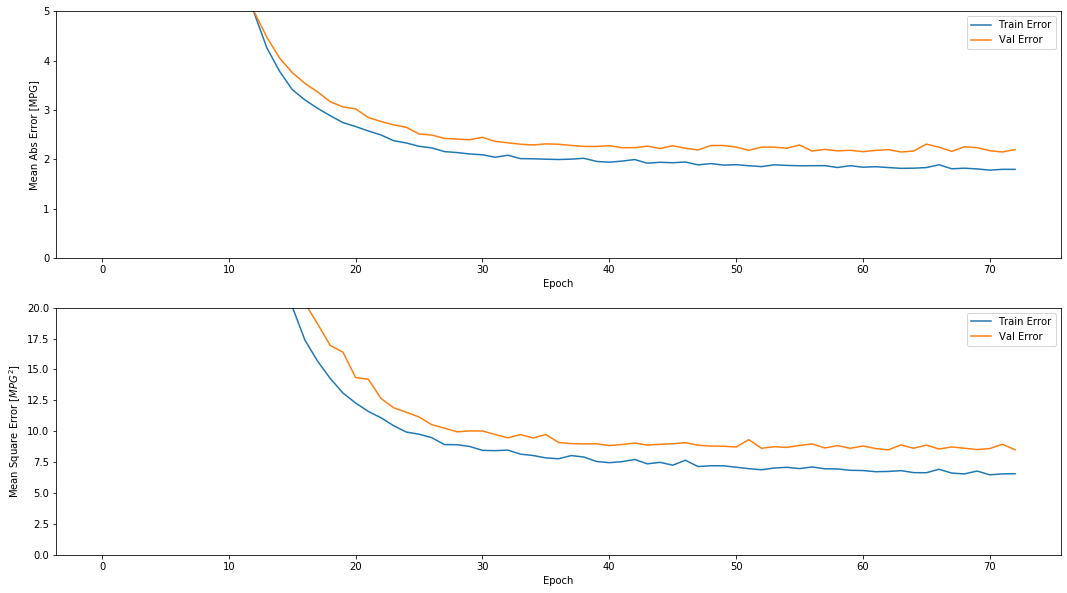

In [15]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

## 7. 使用测试集评估模型

In [16]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.82 MPG


## 8. 在测试集上使用模型预测结果

使用plt图形化显示误差

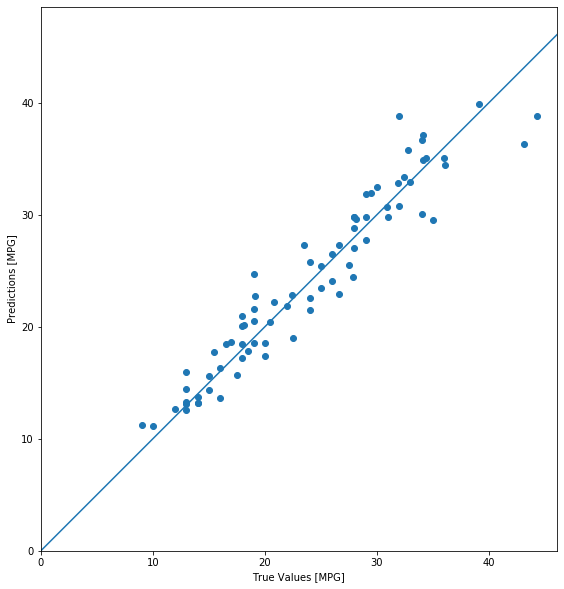

In [17]:
test_predictions = model.predict(normed_test_data).flatten()

plt.figure(figsize=(10, 10))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])

## 9. 看看误差值是否服从高斯正态分布

NOTE: 扩展一下 6 Sigma

Text(0, 0.5, 'Count')

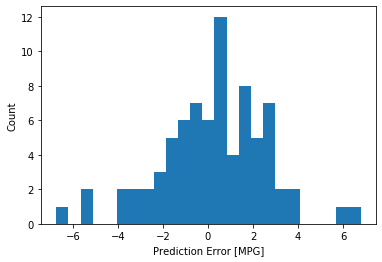

In [18]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")

<img src="./images/gaussian-distribution.jpg" />
<center>
    平均值为 μ 标准差为 σ 的正态分布
</center>